In [1]:
# -*- coding: utf-8 -*-
"""
LSTM模型用于共享单车租赁预测
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# 解决画图中文显示问题
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# 参数设置
look_back = 96  # 输入的历史时间步
epochs = 50  # 迭代次数
batch_size = 64  # 批量大小
input_dim = 9  # 输入特征数
hidden_dim = 64  # 隐藏层神经元数
num_layers = 4  # LSTM层数
dropout = 0.2  # Dropout
learn_rate = 0.0005  # 学习率
T = 240

# 加载数据
# train_data = pd.read_csv('train_data.csv')
# test_data = pd.read_csv('test_data.csv')

data_path = r'../data/'
train_data = pd.read_csv(data_path + 'train_data.csv')
test_data = pd.read_csv(data_path + 'test_data.csv')

# 选择特征和目标列
# features = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
features = [  'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

train_data[features].fillna(0, inplace=True)
train_data[target].fillna(0, inplace=True)


# 数据预处理：归一化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_data[features] = scaler_features.fit_transform(train_data[features])
train_data[target] = scaler_target.fit_transform(train_data[[target]])
test_data[features] = scaler_features.transform(test_data[features])
test_data[target] = scaler_target.transform(test_data[[target]])

train_data[features] = train_data[features].fillna(train_data[features].mean())
test_data[features] = test_data[features].fillna(test_data[features].mean())

features = ['season', 'cnt', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


# 构建时间序列数据
def create_sequences(data, features, target, look_back):
    X, y = [], []
    for i in range(0, len(data) - T-look_back, look_back):
        X.append(data[features].iloc[i:i + look_back].values)
        y.append(data[target].iloc[i + look_back:i + look_back + T].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, features, target, look_back)
X_test, y_test = create_sequences(test_data, features, target, look_back)

# 转换为 PyTorch Tensor 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)#.unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)#.unsqueeze(1)

# 数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, output_dim*2)
        self.fc2 = nn.Linear(output_dim*2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)  # 取最后时间步的输出
        return out

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=T, num_layers=num_layers, dropout=dropout)
model = model.to(device)

# 初始化权重
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

model.apply(init_weights)

# 损失函数与优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learn_rate)

# 梯度裁剪
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# 训练
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        if torch.isnan(loss):
            raise ValueError("Loss became NaN during training.")
        
        loss.backward()
        clip_gradients(model)
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

# 测试
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())


/tmp/ipykernel_2880735/53403523.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features].fillna(0, inplace=True)


Epoch [1/50], Loss: 0.0648
Epoch [2/50], Loss: 0.0509
Epoch [3/50], Loss: 0.0397
Epoch [4/50], Loss: 0.0350
Epoch [5/50], Loss: 0.0331
Epoch [6/50], Loss: 0.0324
Epoch [7/50], Loss: 0.0318
Epoch [8/50], Loss: 0.0311
Epoch [9/50], Loss: 0.0310
Epoch [10/50], Loss: 0.0317
Epoch [11/50], Loss: 0.0316
Epoch [12/50], Loss: 0.0308
Epoch [13/50], Loss: 0.0314
Epoch [14/50], Loss: 0.0311
Epoch [15/50], Loss: 0.0311
Epoch [16/50], Loss: 0.0309
Epoch [17/50], Loss: 0.0306
Epoch [18/50], Loss: 0.0308
Epoch [19/50], Loss: 0.0302
Epoch [20/50], Loss: 0.0301
Epoch [21/50], Loss: 0.0297
Epoch [22/50], Loss: 0.0296
Epoch [23/50], Loss: 0.0293
Epoch [24/50], Loss: 0.0281
Epoch [25/50], Loss: 0.0277
Epoch [26/50], Loss: 0.0259
Epoch [27/50], Loss: 0.0254
Epoch [28/50], Loss: 0.0250
Epoch [29/50], Loss: 0.0242
Epoch [30/50], Loss: 0.0239
Epoch [31/50], Loss: 0.0232
Epoch [32/50], Loss: 0.0220
Epoch [33/50], Loss: 0.0215
Epoch [34/50], Loss: 0.0213
Epoch [35/50], Loss: 0.0217
Epoch [36/50], Loss: 0.0204
E

In [2]:

# 反归一化
# predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
# actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

predictions = (np.array(predictions).reshape(-1, 1))
actuals = (np.array(actuals).reshape(-1, 1))

# 评估
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# 可视化结果


MSE: 0.0474, MAE: 0.1589


In [3]:
y_test

tensor([[0.8035, 0.3930, 0.2661,  ..., 0.0409, 0.1505, 0.4872],
        [0.7298, 0.3910, 0.1679,  ..., 0.0368, 0.1341, 0.1576],
        [0.1781, 0.2723, 0.3552,  ..., 0.0512, 0.1617, 0.5435],
        ...,
        [0.0798, 0.0522, 0.0205,  ..., 0.3439, 0.2467, 0.1720],
        [0.1515, 0.1228, 0.0481,  ..., 0.0594, 0.0532, 0.0430],
        [0.0553, 0.0481, 0.0184,  ..., 0.0645, 0.0450, 0.0266]])

mse: 0.04815446636745368
mae: 0.15972823593553834


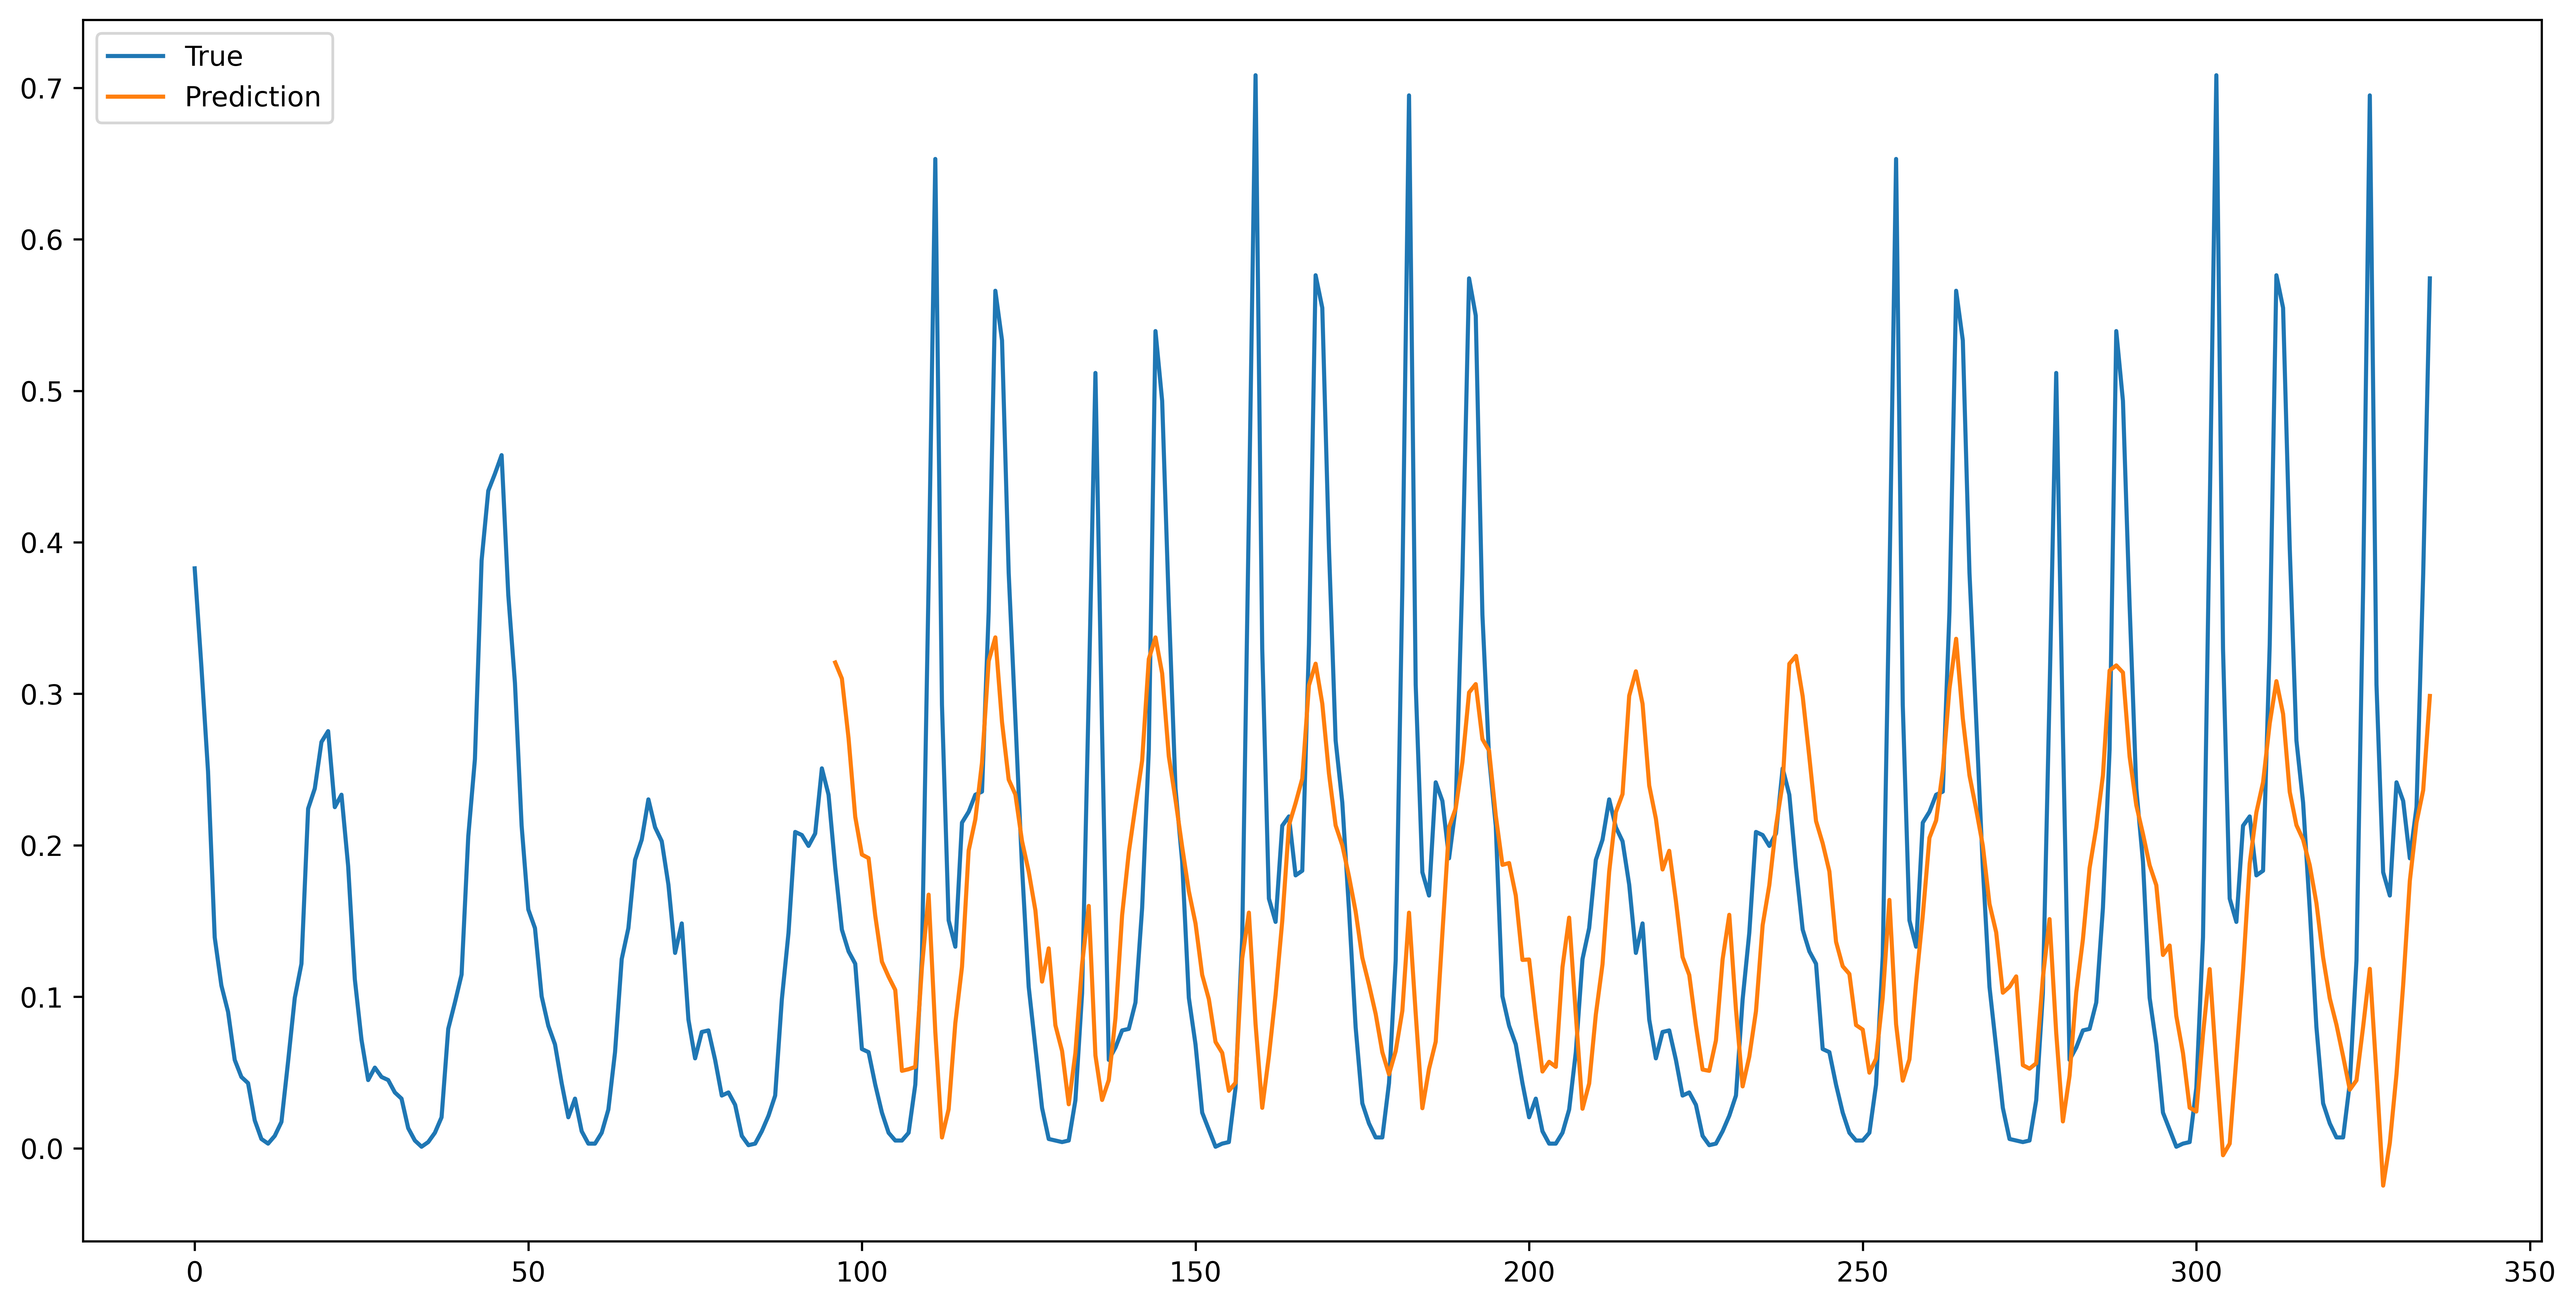

In [ ]:


best_i = -1
mse = float('inf')
mse_list = []
mae_list = []
for i in range(len(actuals)-96-T):
    # tmp = mean_absolute_error(actuals[i+96:i+96+T], predictions[i:i+T])
    tmp = mean_absolute_error(actuals[i:i+T], predictions[i:i+T])
    mae_list.append(tmp)
    mse_list.append(mean_squared_error(actuals[i:i+T], predictions[i:i+T]))
    if tmp < mse:
        mse = tmp
        best_i = i

print('mse:', sum(mse_list)/len(mse_list))
print('mae:', sum(mae_list)/len(mae_list))


i = best_i
y1 = np.concatenate((actuals[i:i+96], actuals[i+96:i+96+T]))
y2 = predictions[i:i+T]

# 计算两条曲线的 x 轴范围
x1 = np.arange(len(y1))  # x1: [0, 1, 2, 3]
x2 = np.arange(len(y1) - len(y2), len(y1))  # x2: [2, 3]
plt.figure(figsize=(16, 8), dpi=600)
# 绘制曲线
plt.plot(x1, y1, label="cnt")  # 第一条曲线
plt.plot(x2, y2, label="Groud Truth")  # 第二条曲线

# 添加图例和标题
plt.legend()

# plt.xlabel("X")
# plt.ylabel("Y")

# 显示图形
plt.show()


In [5]:
mse

0.0995138

In [6]:
i

2684